# Currency exchange example

Dataset used is the currency enchange with respect to USD dollars, from daily measurements from the last 2 years (2017-2018).

Currencies used: 
- Reference: USA
- Canadian dollar (CAD)
- Euro (EUR)
- Japanese yen (JPY)
- Great british pound (GBP)
- Swiss franc (CHF)
- Austrial dollar (AUD)
- Hong Kong dollar (HKD)
- New zealand dollar (NZD)
- South korean won (KRW)
- Mexican peso (MXN)

Please see our publication at https://doi.org/10.1109/ICASSP40776.2020.9054102 for a full description of this data set and the interpretations of our results.

In [1]:
import mogptk
import numpy as np
import pandas as pd

## Data loading

In [2]:
column_names = ['EUR/USD', 'CAD/USD', 'JPY/USD', 'GBP/USD', 'CHF/USD',
                'AUD/USD', 'HKD/USD','NZD/USD', 'KRW/USD','MXN/USD']

dataset = mogptk.DataSet()
for names in column_names:
    dataset.append(mogptk.LoadCSV('data/currency_exchange/final_dataset.csv',
                                    x_col='Date', y_col=names))

dataset.filter('2017-01-03', '2018-01-01')

In [3]:
# Preprocess by randomly removing points and detrending
for i, channel in enumerate(dataset):
    channel.transform(mogptk.TransformDetrend)
    channel.transform(mogptk.TransformNormalize())
    channel.remove_randomly(pct=0.3)
    
    if i not in [0, 2, 5]:
        channel.remove_range('2017-11-17', None)
    
# simulate sensor failure
dataset[1].remove_range('2017-03-31', '2017-05-01')
dataset[2].remove_range('2017-12-28', None)
dataset[3].remove_range('2017-07-20', '2017-09-08')
dataset[4].remove_range(None, '2017-01-31')
dataset[5].remove_range('2017-12-28', None)
dataset[7].remove_range(None, '2017-01-31')

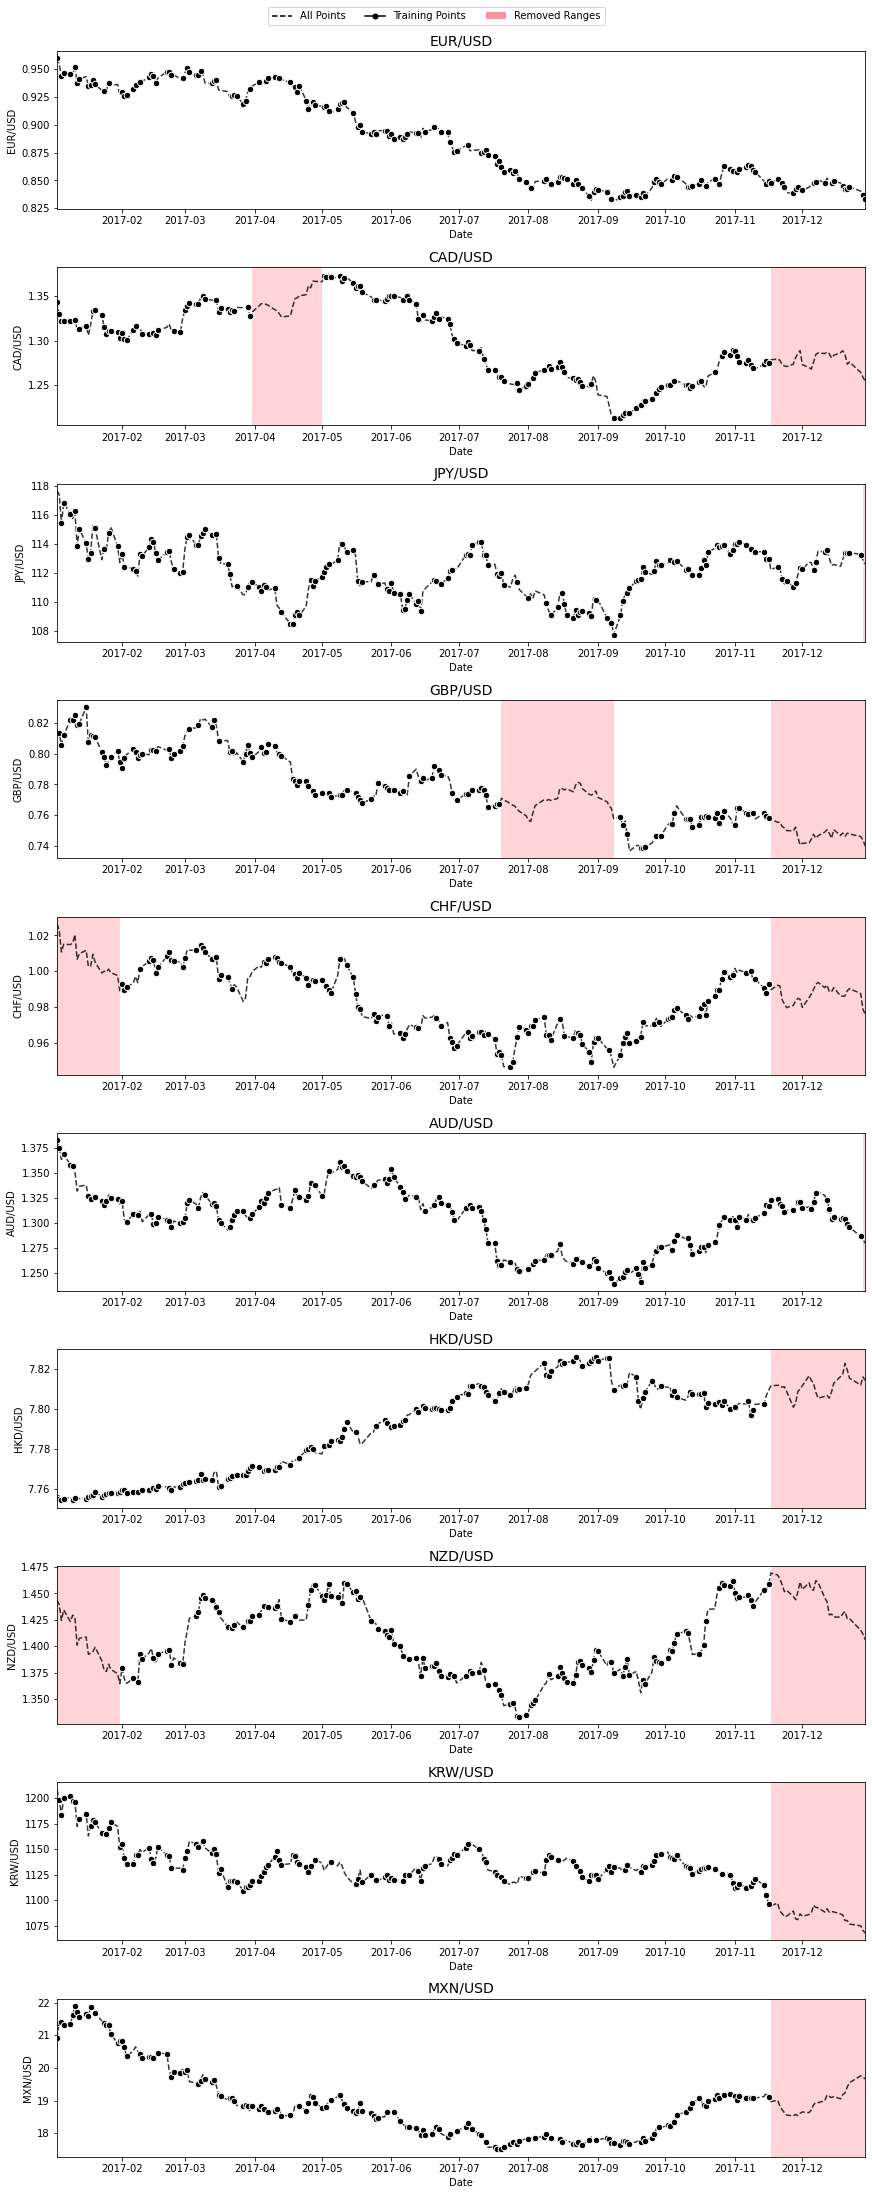

In [4]:
dataset.plot();

In [5]:
n_trials = 3
Q = 3
init_method = 'BNSE'
method = 'Adam'
lr = 0.2
iters = 500

## Multi-output spectral mixture kernel

In [6]:
mosm_models = []
mosm_mae = np.zeros((n_trials,10))
mosm_rmse = np.zeros((n_trials,10))
mosm_mape = np.zeros((n_trials,10))

# experiment trials
for n in range(n_trials):
    mosm_dataset = dataset.copy()
    for i, channel in enumerate(mosm_dataset):
        channel.remove_randomly(pct=0.3)
        
    print('\nTrial', n+1, 'of', n_trials)
    mosm = mogptk.MOSM(mosm_dataset, Q=Q)
    mosm.init_parameters(init_method)
    mosm.train(method=method, lr=lr, iters=iters, verbose=True)
    mosm_models.append(mosm)
    print('=' * 50)
    
    error = mogptk.error(mosm, per_channel=True)[0]
    mosm_mae[n,:] = np.array([item['MAE'] for item in error])
    mosm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    mosm_mape[n,:] = np.array([item['MAPE'] for item in error])


Trial 1 of 3

Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 10
‣ Mixtures: 3
‣ Training points: 1103
‣ Parameters: 181
‣ Initial loss: 1.15e+03


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(np.c_[mosm_mae.mean(1), mosm_rmse.mean(1), mosm_mape.mean(1),
             mosm_mae.std(1), mosm_rmse.std(1), mosm_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

In [ ]:
best_mosm = mosm_models[np.argmin(mosm_mape.mean(1))]
best_mosm.predict()
best_mosm.plot_prediction();

## Cross spectral mixture kernel

In [ ]:
csm_models = []
csm_mae = np.zeros((n_trials,10))
csm_rmse = np.zeros((n_trials,10))
csm_mape = np.zeros((n_trials,10))

for n in range(n_trials):
    csm_dataset = dataset.copy()
    for i, channel in enumerate(csm_dataset):
        channel.remove_randomly(pct=0.3)
        
    print('\nTrial', n+1, 'of', n_trials)
    csm = mogptk.CSM(csm_dataset, Q=Q)
    csm.init_parameters(init_method)    
    csm.train(method=method, lr=lr, iters=iters, verbose=True)
    csm_models.append(csm)
    print('=' * 50)
    
    error = mogptk.error(csm, per_channel=True)[0]
    csm_mae[n,:] = np.array([item['MAE'] for item in error])
    csm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    csm_mape[n,:] = np.array([item['MAPE'] for item in error])

In [ ]:
pd.DataFrame(np.c_[csm_mae.mean(1), csm_rmse.mean(1), csm_mape.mean(1),
             csm_mae.std(1), csm_rmse.std(1), csm_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

In [ ]:
best_csm = csm_models[np.argmin(csm_mape.mean(1))]
best_csm.predict()
best_csm.plot_prediction();

## Linear model of coregionalization with spectral mixture kernels

In [ ]:
smlmc_models = []
smlmc_mae = np.zeros((n_trials,10))
smlmc_rmse = np.zeros((n_trials,10))
smlmc_mape = np.zeros((n_trials,10))

for n in range(n_trials):
    smlmc_dataset = dataset.copy()
    for i, channel in enumerate(smlmc_dataset):
        channel.remove_randomly(pct=0.3)
        
    print('\nTrial', n+1, 'of', n_trials)
    smlmc = mogptk.SM_LMC(smlmc_dataset, Q=Q)
    smlmc.init_parameters(init_method)
    smlmc.train(method=method, lr=lr, iters=iters, verbose=True)
    smlmc_models.append(smlmc)
    print('=' * 50)

    error = mogptk.error(smlmc, per_channel=True)[0]
    smlmc_mae[n,:] = np.array([item['MAE'] for item in error])
    smlmc_rmse[n,:] = np.array([item['RMSE'] for item in error])
    smlmc_mape[n,:] = np.array([item['MAPE'] for item in error])

In [ ]:
pd.DataFrame(np.c_[smlmc_mae.mean(1), smlmc_rmse.mean(1), smlmc_mape.mean(1),
             smlmc_mae.std(1), smlmc_rmse.std(1), smlmc_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

In [ ]:
best_smlmc = smlmc_models[np.argmin(smlmc_mape.mean(1))]
best_smlmc.predict()
best_smlmc.plot_prediction();

## Independent spectral mixture kernels

In [ ]:
sm_models = []
sm_mae = np.zeros((n_trials,10))
sm_rmse = np.zeros((n_trials,10))
sm_mape = np.zeros((n_trials,10))

for n in range(n_trials):
    sm_dataset = dataset.copy()
    for i, channel in enumerate(sm_dataset):
        channel.remove_randomly(pct=0.3)
    
    print('\nTrial', n+1, 'of', n_trials)
    sm = mogptk.SM(sm_dataset, Q=Q)
    sm.init_parameters(init_method)
    sm.train(method=method, lr=lr, iters=iters, verbose=True)
    sm_models.append(sm)
    print('=' * 50)
        
    error = mogptk.error(sm, per_channel=True)[0]
    sm_mae[n,:] = np.array([item['MAE'] for item in error])
    sm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    sm_mape[n,:] = np.array([item['MAPE'] for item in error])

In [ ]:
pd.DataFrame(np.c_[sm_mae.mean(1), sm_rmse.mean(1), sm_mape.mean(1),
             sm_mae.std(1), sm_rmse.std(1), sm_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

In [ ]:
best_sm = sm_models[np.argmin(sm_mape.mean(1))]
best_sm.predict()
best_sm.plot_prediction();

## Results

In [ ]:
print('MAPE errors per model')
print('MOSM:    %g ± %g' % (mosm_mape.mean(1).mean(), mosm_mape.mean(1).std()))
print('CSM:     %g ± %g' % (csm_mape.mean(1).mean(), csm_mape.mean(1).std()))
print('SM-LMC:  %g ± %g' % (smlmc_mape.mean(1).mean(), smlmc_mape.mean(1).std()))
print('SM:      %g ± %g' % (sm_mape.mean(1).mean(), sm_mape.mean(1).std()))